<a href="https://colab.research.google.com/github/isabernardes/Odd-Odin/blob/main/Baseline_ODIN_ood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Standard libraries
import os
import math
import numpy as np 
import time

##Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.utils import make_grid


## Imports for plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {}

# Dataset & Data loaders

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


['.DS_Store', 'farmland', 'playground', 'resort', 'park', 'square', 'baseballfield', 'pond', 'church', 'center', 'bridge', 'denseresidential', 'industrial', 'viaduct', 'mediumresidential', 'port', 'sparseresidencial', 'railwaystation', 'commercial', 'airport', 'stadium', 'school', 'storagetanks', 'parking']
torch.Size([3, 224, 224]) 3
Label:  center (3)


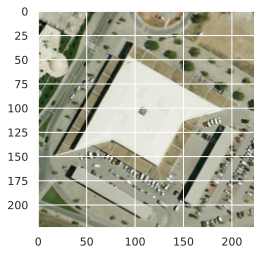

In [26]:
# Download test dataset
data_folder_test = "/content/drive/MyDrive/Project B/04_RSICD/test"
data_folder_train = "/content/drive/MyDrive/Project B/04_RSICD/train"
transform= transforms.Compose([transforms.ToTensor()])
batch_size=28

data = torchvision.datasets.ImageFolder(root = data_folder_train, transform = transform)
data_test = torchvision.datasets.ImageFolder(root = data_folder_test, transform = transform)
data_loader = torch.utils.data.DataLoader(data, batch_size, shuffle=True,  num_workers=2)
data_loader_test = torch.utils.data.DataLoader(data_test, batch_size, shuffle=True,  num_workers=2)


classes = os.listdir(data_folder_train)
print(classes)

img, label = data[760]
print(img.shape, label)

def show_example(img, label):
    print('Label: ', data.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

show_example(*data[760])




In [4]:
random_seed = 22
torch.manual_seed(random_seed);

print(len(data))

val_size = 500
train_size = len(data) - val_size

train_ds, val_ds = random_split(data, [train_size, val_size])
len(train_ds), len(val_ds)

6375


(5875, 500)

tensor([16, 19,  8,  8, 13,  5,  9, 21,  3, 17, 11, 11,  0,  6, 13,  3, 18, 11,
        13,  0,  6,  7, 12,  7, 13, 14,  7, 22])


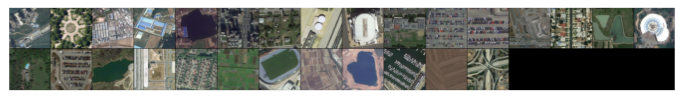

In [5]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        print(labels)
        break
show_batch(train_dl)


In [6]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

cov = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
cov.weight.shape
cov.weight[0]

images.shape: torch.Size([28, 3, 224, 224])
out.shape: torch.Size([28, 8, 112, 112])


tensor([[[ 0.0948,  0.0946,  0.0545],
         [ 0.1291, -0.0443, -0.1479],
         [ 0.1433,  0.0014,  0.1322]],

        [[-0.0363, -0.1153, -0.0236],
         [ 0.1845, -0.0193, -0.1438],
         [-0.0758,  0.0849,  0.1315]],

        [[ 0.0180, -0.1381,  0.1634],
         [ 0.0193, -0.0784, -0.0145],
         [ 0.0466,  0.0904,  0.1427]]], grad_fn=<SelectBackward0>)

In [7]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Model



In [8]:
class Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 112 x 112

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 56 x 56

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 28 x 28

            nn.Flatten(), 
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 23))
        
    def forward(self, xb):
        return self.network(xb)

In [9]:
model = Model()
model


Model(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=200704, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=102

In [10]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([28, 3, 224, 224])
out.shape: torch.Size([28, 23])
out[0]: tensor([-0.0122, -0.0258, -0.0021,  0.0299, -0.0312, -0.0369, -0.0023,  0.0035,
         0.0294,  0.0227, -0.0072, -0.0180, -0.0143,  0.0100, -0.0054,  0.0465,
         0.0249,  0.0164,  0.0214, -0.0319, -0.0174, -0.0295, -0.0054],
       grad_fn=<SelectBackward0>)


In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device


train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

# Training

In [12]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [13]:
model = to_device(Model(), device)

# Prediction


In [14]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


evaluate(model, val_dl)


{'val_acc': 0.05815018713474274, 'val_loss': 3.137617588043213}

In [18]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.0001

In [19]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.7153, val_loss: 1.8510, val_acc: 0.4280
Epoch [1], train_loss: 1.4517, val_loss: 1.6539, val_acc: 0.5076
Epoch [2], train_loss: 1.1854, val_loss: 1.6031, val_acc: 0.5299
Epoch [3], train_loss: 0.8598, val_loss: 1.6322, val_acc: 0.5597
Epoch [4], train_loss: 0.5635, val_loss: 1.8881, val_acc: 0.5375
Epoch [5], train_loss: 0.2684, val_loss: 2.4489, val_acc: 0.5258
Epoch [6], train_loss: 0.1679, val_loss: 2.7011, val_acc: 0.5356
Epoch [7], train_loss: 0.1666, val_loss: 2.6531, val_acc: 0.5295
Epoch [8], train_loss: 0.0943, val_loss: 2.3071, val_acc: 0.5601
Epoch [9], train_loss: 0.0340, val_loss: 3.4601, val_acc: 0.5276


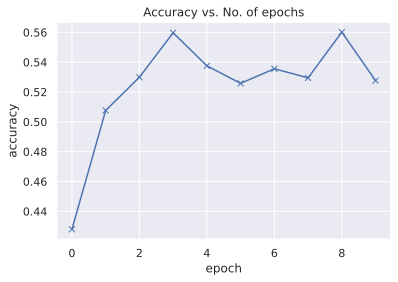

In [20]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)


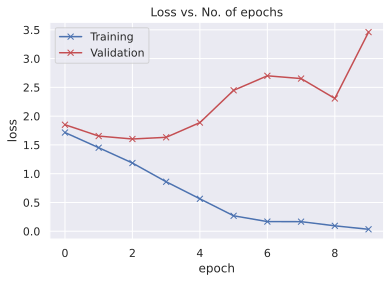

In [22]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)


In [23]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return data.classes[preds[0].item()]

Label: playground , Predicted: industrial


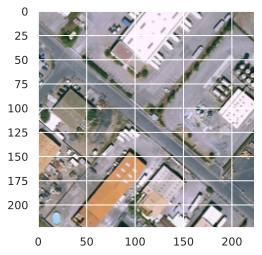

In [31]:
img, label = data_test[700]
plt.imshow(img.permute(1, 2, 0))
print('Label:', data.classes[label], ', Predicted:', predict_image(img, model))

In [34]:
test_loader = DeviceDataLoader(DataLoader(data_test, batch_size*2), device)
result = evaluate(model, test_loader)


RuntimeError: ignored

#Implemenatin ODIN

    #def odin_preprocessing(model, input, epsilon):
    # 1. Set requires_grad attribute of tensor.
    TODO
    # 2. Forward pass the data through the model
    TODO
    # 3. Calculate the loss w.r.t to class predictions
    TODO
    # 4. Zero all existing gradients
    TODO
    # 5. Calculate gradients of model in backward pass
    TODO
    # 6. Collect sign of datagrad
    TODO
    # 7. Normalizing the gradient to the same space of image
    TODO
      sign_input_grad = sign_input_grad / 0.3081
    # 8. Apply FGSM Attack
    TODO
    #return perturbed_input


    #Compute predictions for ODIN 
    TODO

    # Obtaining precision and recall plot vector + AUPR
    TODO

In [ ]:
def perturb_images(images, model, epsilon=0.04):

    test_ds_var = tf.Variable(images, trainable=True)

    with tf.GradientTape() as tape:
        # Calculate the scores.
        tape.watch(test_ds_var)
        logits = model(test_ds_var, training=False)
        loss = tf.reduce_max(logits, axis=1)
        loss = -tf.reduce_mean(loss)

    # Calculate the gradients of the scores with respect to the inputs.
    gradients = tape.gradient(loss, test_ds_var)
    gradients = tf.math.greater_equal(gradients, 0)
    gradients = tf.cast(gradients, tf.float32)
    gradients = (gradients - 0.5) * 2

    # Perturb the inputs and derive new mean score.
    # test_ds_var.assign_add(epsilon * gradients)
    static_tensor = tf.convert_to_tensor(test_ds_var)
    static_tensor = static_tensor - epsilon * gradients
    static_tensor = tf.clip_by_value(static_tensor, 0., 255.)
    
    return static_tensor

In [ ]:
# We first perturb the images from both of the datasets.

def create_pertubed_ds(ds, model, ds_name):
    num_samples = NUM_SAMPLE_MAPPING[ds_name]
    perturbed_images = np.zeros((num_samples, 32, 32, 3))
    unchanged_labels = np.zeros((num_samples, ))
    
    for i, (image, label) in enumerate(tqdm(ds)):
        image = tf.expand_dims(image, 0)
        perturbed_images[i] = perturb_images(image, model)
        unchanged_labels[i] = label
    
    perturbed_ds = tf.data.Dataset.from_tensor_slices((perturbed_images, unchanged_labels))
    return perturbed_ds

In [ ]:
perturbed_svhn = create_pertubed_ds(svhn_test, scorer, "svhn")
pertubed_cifar10 = create_pertubed_ds(cifar10_test, scorer, "cifar10_test")

In [ ]:
# We create new data loaders.
perturbed_svhn = perturbed_svhn.batch(BATCH_SIZE)
pertubed_cifar10 = pertubed_cifar10.batch(BATCH_SIZE)

In [ ]:
# Calculate AUROC.
print(metrics.metric(pertubed_cifar10, perturbed_svhn, rn_odin_model, stype="generalized_odin"))

In [ ]:
# Baseline AUROC (with perturbation).
cifar10_test = pertubed_cifar10.batch(BATCH_SIZE)
print(metrics.metric(pertubed_cifar10, perturbed_svhn, rn_baseline_model, stype="baseline"))